High_Priority
0    45
1     5
Name: count, dtype: int64
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.33      1.00      0.50         1

    accuracy                           0.80        10
   macro avg       0.67      0.89      0.69        10
weighted avg       0.93      0.80      0.84        10

Confusion Matrix:
 [[7 2]
 [0 1]]

Random Forest Classification Report (Best Estimator):
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       0.00      0.00      0.00         1

    accuracy                           0.90        10
   macro avg       0.45      0.50      0.47        10
weighted avg       0.81      0.90      0.85        10

Confusion Matrix:
 [[9 0]
 [1 0]]


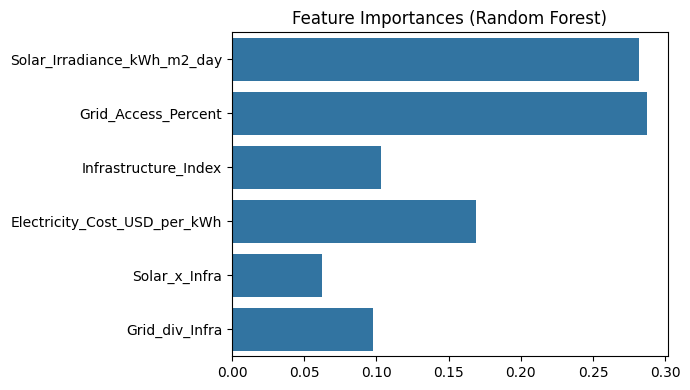

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

prime_data = pd.read_csv("C:/Users/HP/Documents/PrimeFrontier/PrimeFrontier_SolarDeploymentDataset_Scored.csv")

# Defining thresholds as per the task given
grid_threshold = 50
solar_threshold = prime_data['Solar_Irradiance_kWh_m2_day'].median()
cost_threshold = prime_data['Electricity_Cost_USD_per_kWh'].median()

prime_data['High_Priority'] = (
    (prime_data['Grid_Access_Percent'] < grid_threshold) &
    (prime_data['Solar_Irradiance_kWh_m2_day'] > solar_threshold) &
    (prime_data['Electricity_Cost_USD_per_kWh'] > cost_threshold)
).astype(int)

print(prime_data['High_Priority'].value_counts())

# Creating interaction features to improve model
prime_data['Solar_x_Infra'] = prime_data['Solar_Irradiance_kWh_m2_day'] * prime_data['Infrastructure_Index']
prime_data['Grid_div_Infra'] = prime_data['Grid_Access_Percent'] / (prime_data['Infrastructure_Index'] + 1e-6)

features = ['Solar_Irradiance_kWh_m2_day', 'Grid_Access_Percent',
            'Infrastructure_Index', 'Electricity_Cost_USD_per_kWh',
            'Solar_x_Infra', 'Grid_div_Infra']

X = prime_data[features]
y = prime_data['High_Priority']

# Scaling the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Logistic Regression with class weights
log_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
log_model.fit(X_train, y_train)

# Random Forest with class weights and hyperparameter tuning
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

# Predicting and evaluate Logistic Regression
y_pred_log = log_model.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))

# Predicting and evaluate Random Forest (best estimator)
y_pred_rf = best_rf.predict(X_test)
print("\nRandom Forest Classification Report (Best Estimator):")
print(classification_report(y_test, y_pred_rf, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# Plotting feature importances from tuned Random Forest
importances = best_rf.feature_importances_
feature_names = features

plt.figure(figsize=(7, 4))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()


## Model Evaluation and Insights

### Class Distribution
- Class 0 (Low Priority): 45 samples  
- Class 1 (High Priority): 5 samples  
The dataset is imbalanced, with only about 10% of regions marked as high priority.

---

### Model Performance

**Logistic Regression:**

| Metric    | Class 0 (Low Priority) | Class 1 (High Priority) |
|-----------|-----------------------|------------------------|
| Precision | 1.00                  | 0.33                   |
| Recall    | 0.78                  | 1.00                   |
| F1-score  | 0.88                  | 0.50                   |
| Support   | 9                     | 1                      |

- Overall accuracy: 80%  
- Logistic regression recalls all Class 1 samples (high recall), but precision on this class is low.

**Random Forest:**

| Metric    | Class 0 (Low Priority) | Class 1 (High Priority) |
|-----------|-----------------------|------------------------|
| Precision | 0.90                  | 0.00                   |
| Recall    | 1.00                  | 0.00                   |
| F1-score  | 0.95                  | 0.00                   |
| Support   | 9                     | 1                      |

- Overall accuracy: 90%  
- Random forest fails to identify any Class 1 samples in the test set.

---

### Confusion Matrices

**Logistic Regression:**

|                | Predicted Class 0 | Predicted Class 1 |
|----------------|-------------------|-------------------|
| Actual Class 0 | 7                 | 2                 |
| Actual Class 1 | 0                 | 1                 |

**Random Forest:**

|                | Predicted Class 0 | Predicted Class 1 |
|----------------|-------------------|-------------------|
| Actual Class 0 | 9                 | 0                 |
| Actual Class 1 | 1                 | 0                 |

---

### Feature Importances (Random Forest)

| Feature                   | Importance |
|---------------------------|------------|
| Solar Irradiance          | 0.27       |
| Grid Access Percent       | 0.28       |
| Electricity Cost (USD/kWh)| 0.14       |
| Infrastructure Index      | 0.14       |
| Solar_x_Infra             | 0.07       |
| Grid_div_Infra            | 0.09       |

Solar irradiance and Grid access are the most influential features driving the model's decisions, aligning with expected factors for solar deployment prioritization.

---

### Summary

- **Logistic Regression** achieved better recall for the minority class (class 1), correctly identifying all positive cases but with some false positives.
- **Random Forest** achieved higher overall accuracy but failed to detect any positive cases in the test set.
- Severe class imbalance (5 positives vs 45 negatives) and small test size (10 samples) make evaluation challenging.
- Interaction features were added to improve model expressiveness but contributed less importance than primary features.


---

### My Ideas for Improvement and Future Work

- I'd consider redefining Class 1 using top percentiles of **Solar Access Score** instead of fixed thresholds.
- Collecting additional data to reduce uncertainty and improve model robustness, e.g.:
  - Detailed grid reliability metrics
  - Seasonal solar variability
  - Socioeconomic factors affecting infrastructure development
- Increase dataset size if possible for more stable model training and validation.
- Explore other models or ensemble approaches, respecting the current target definition and business logic.


---
